In [69]:
import torch
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [70]:
model = torch.jit.load('/home/hardy/projects/yoloPHP/model/yolov8n.torchscript')
model.eval()
print("Model loaded")

Model loaded


In [71]:
image_path = '../testInput.jpg'
image = Image.open(image_path).convert('RGB')
original_size = image.size
print(f"Original size: {original_size}")

Original size: (2048, 1152)


In [72]:
image_resized = image.resize((640, 640))
image_np = np.array(image_resized)

In [73]:
input_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float().div(255).unsqueeze(0)

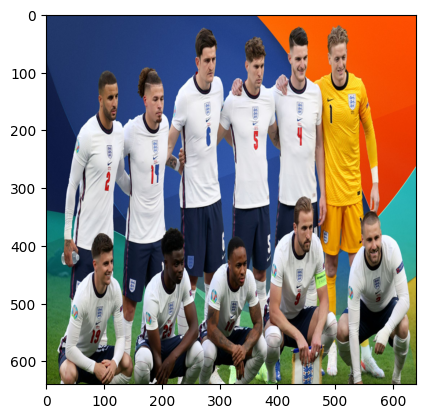

In [74]:
plt.imshow(image_resized)
plt.show()

In [75]:
with torch.no_grad():
    outputs = model(input_tensor)

In [76]:
outputs = outputs[0].cpu().numpy().transpose(1, 0)
rows = outputs.shape[0]

In [77]:
boxes = []
scores = []
class_ids = []

In [83]:
for i in range(rows):
    classes_scores = outputs[i, 4:]
    (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_scores)
    if maxScore >= 0.25:
        box = [
            outputs[i, 0] - (0.5 * outputs[i, 2]),
            outputs[i, 1] - (0.5 * outputs[i, 3]),
            outputs[i, 2],
            outputs[i, 3],
        ]
        boxes.append(box)
        scores.append(maxScore)
        class_ids.append(maxClassIndex)

# Apply NMS (Non-maximum suppression)
indices = cv2.dnn.NMSBoxes(boxes, scores, 0.25, 0.45)

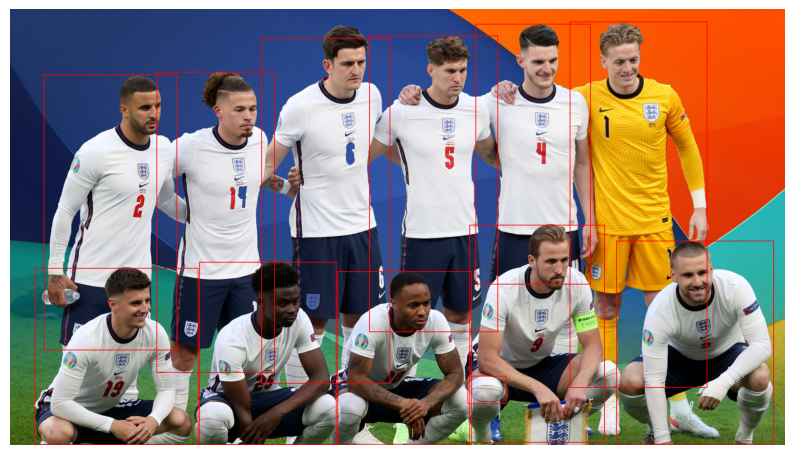

In [86]:
image = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(image)
scale_x, scale_y = original_size[0] / 640, original_size[1] / 640
for i in indices:
    box = boxes[i]
    x0, y0, x1, y1 = box[0] * scale_x, box[1] * scale_y, (box[0] + box[2]) * scale_x, (box[1] + box[3]) * scale_y
    if x1 > x0 and y1 > y0:  # Invalid boxes
        draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
    else:
        print(f"Skipped invalid box: {box}")

# Convert image to numpy array for plotting
image_np = np.array(image)

plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.axis('off')
plt.show()